<b>#-----------------------------------------Cardio Vascular Disease Prediction-----------------------------------------------#</b>

In [11]:
# This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are
# Source : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
# Cleveland: 303 observations
# Hungarian: 294 observations
# Switzerland: 123 observations
# Long Beach VA: 200 observations
# Stalog (Heart) Data Set: 270 observations
# Final dataset: 918 observations ( Curated)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings("ignore")

<b>##################################################Data Collection & Loading#########################################################</b>

In [3]:
#https://raw.githubusercontent.com/sharmaroshan/Heart-UCI-Dataset/master/heart.csv
df = pd.read_csv('datasources/heartdisease_combined.csv')
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


<b>##################################################Data Visualization#########################################################</b>

In [4]:
# Peek Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


<Figure size 800x550 with 0 Axes>

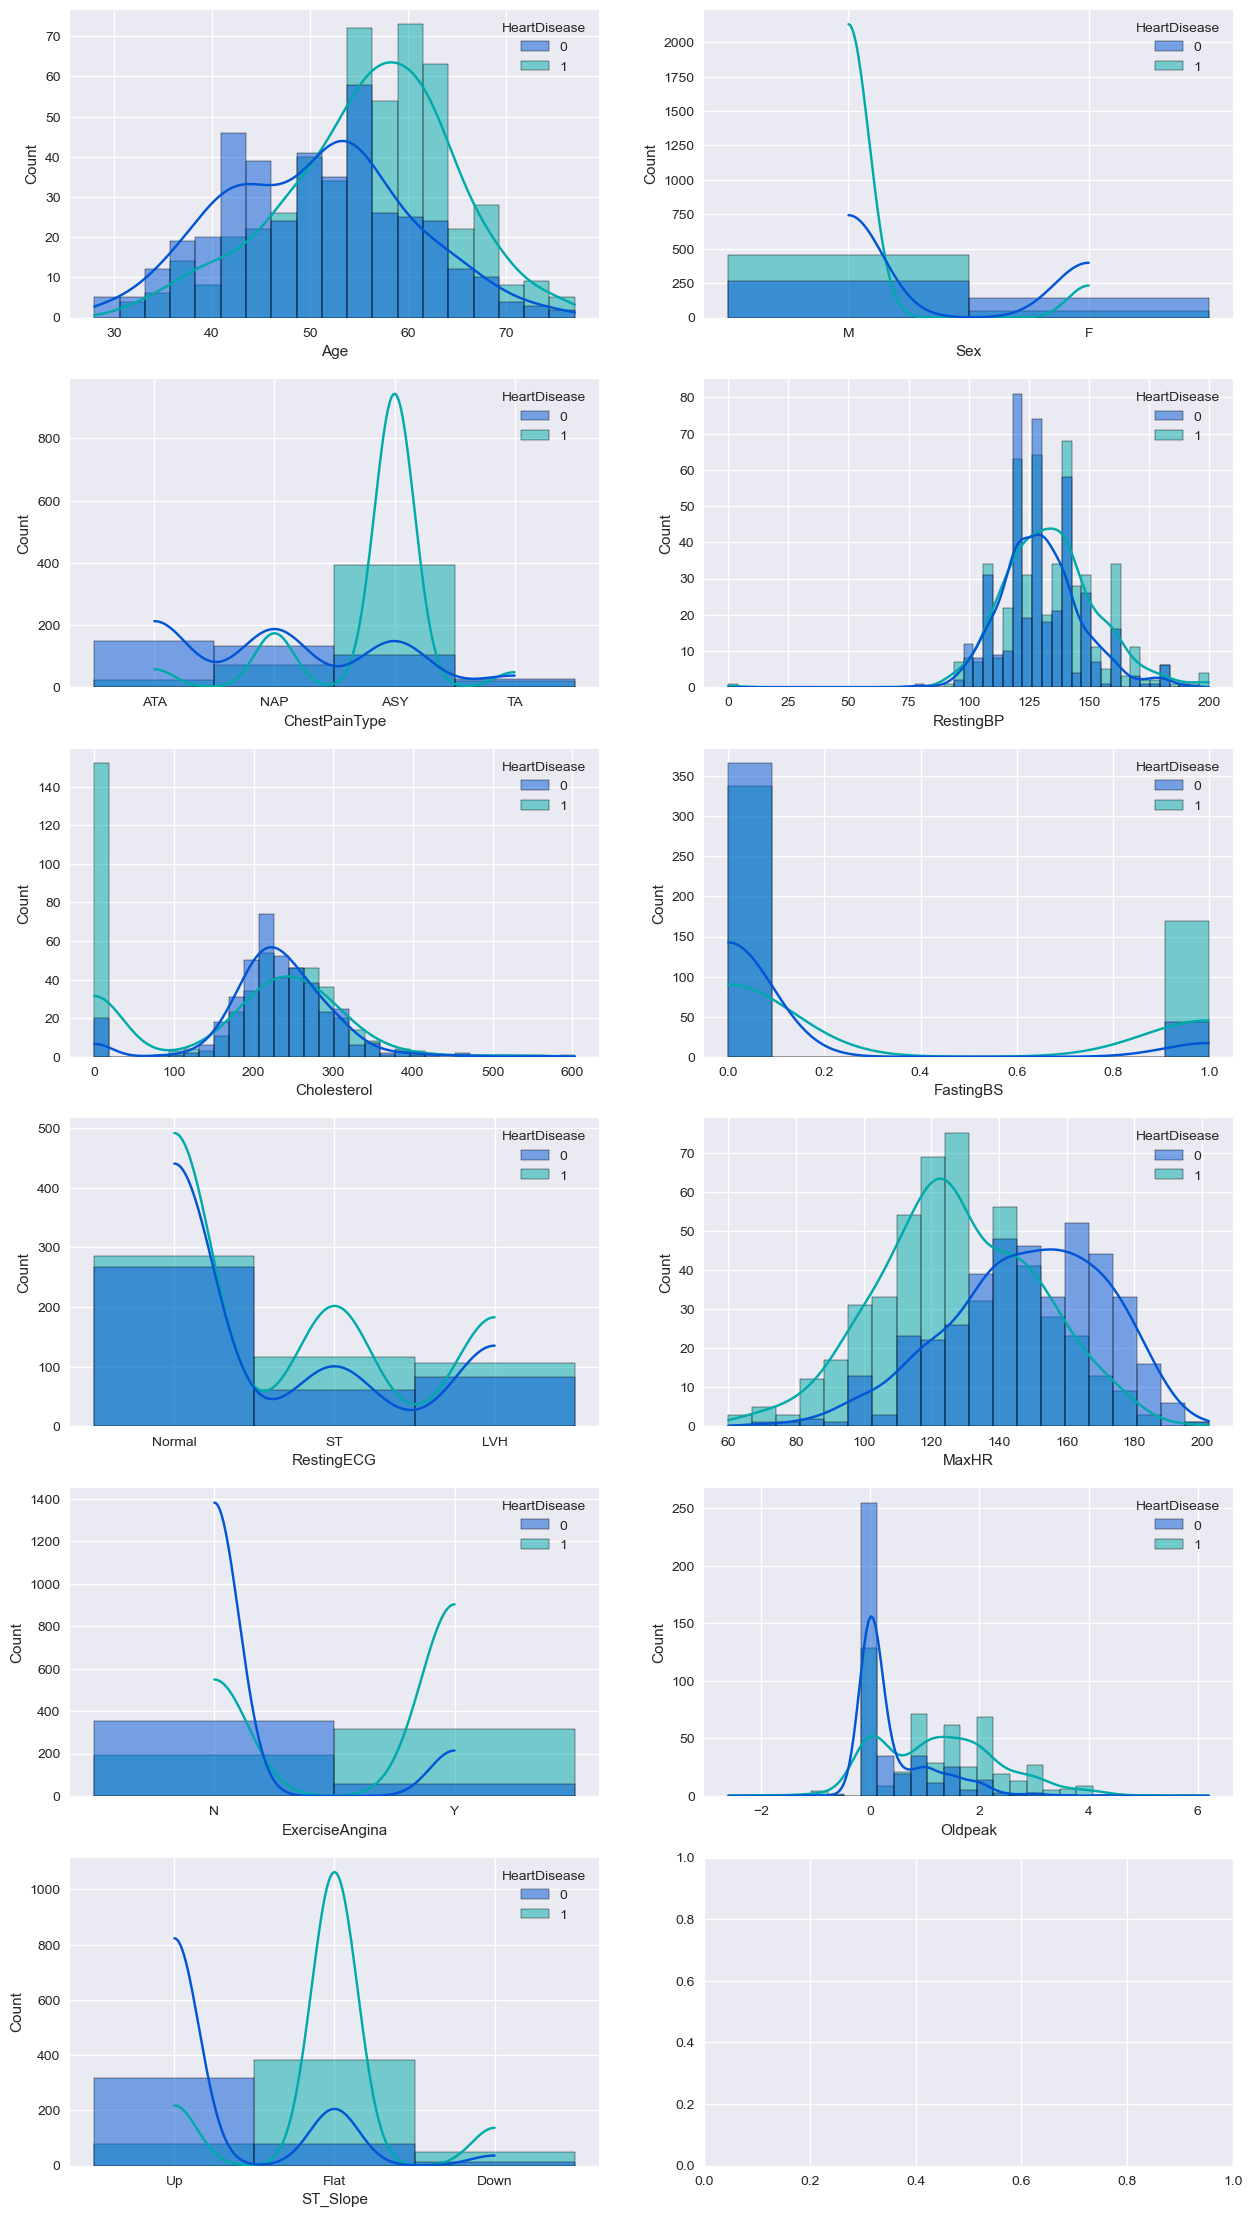

In [31]:
# Inference 
# 1. Age: We see how the risk of suffering cardiovascular diseases (CVDs) increases with age.
# 2. Sex : Apparently men have a major risk of suffering CVD's 
# 3. ChestPainType: The majority cases of CVDs present absence of chest pain or the usual anginal equivalents. Followed by the cases that present chest pain non-anginal.
# 4. RestingBP: the high blood pressure can drive to suffering CVDs. We see in this histogram a slight increase in the CVDs cases when increase the resting blood pressure. 
# 5. Cholesterol: a high level of cholesterol can lead to stroke, heart attack, or even heart failure
#    Three cholesterol types that compose a serum cholesterol, HDL or 'good' cholesterol, LDL or 'bad' cholesterol and triglycerides(TG), 
#    Where high HDL levels are better than high LDL and TG levels
#    A serum cholesterol major than 200 mm/dl is considered a risk factor for health
# 6. FastingBS:high blood sugar can damage blood vessels and the nerves that control your heart. majority of patients with high blood sugar have CVDs
# 7. RestingECG : The majority cases of patients with CVDs present normal resting electrocardiograms, 
#    We observe that in the cases that present ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
#    the amount of patients with CVDs are two times more than patients that not suffering CVDs, 
# 8. MaxHR : Patients with CVDs present low values of maximum heart rate, while that patients with normal conditions present values more high
# 9. ExerciseAngina :  Angina is chest pain or discomfort caused when your heart muscle doesn't get enough oxygen-rich blood. 
#    majority of patients with CVDs present exercise-induced angina
# 10.Oldpeak:
# 11.ST_slope:According to Ecgwaves's article, upsloping ST segment can be generally considered like normal, 
#    but so much flat or horizontal ST segment and dowsloping ST segment can be considered like anomalies,

plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2)
color = 'winter'

#fig, axs = plt.subplots(6, 2, figsize=(15,28))
fig, axs = plt.subplots(6, 2, figsize=(15,28))
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and i < 14:
        plt.subplot(6,2,i)
        sns.histplot(data=df, x=feature, kde=True, palette=color, hue='HeartDisease')
        i+=1

<b>##################################################Data Cleaning#########################################################</b>

<b>-------------------------------------Identify Missing Values / Fix Missing Values ----------------------</b>

In [6]:
numeric_vars = df.columns[df.dtypes != 'object']
categorical_vars = df.columns[df.dtypes == 'object']
# List out columns and their counts of missing values - sorted 
print('--------------Numerical Counts of Missing Values ( Sorted ) --------------------')
print(df[numeric_vars].isnull().sum().sort_values(ascending=False))

print('--------------Categorical Counts of Missing Values --------------------')
print(df[categorical_vars].isnull().sum().sort_values(ascending=False))

--------------Numerical Counts of Missing Values ( Sorted ) --------------------
Age             0
RestingBP       0
Cholesterol     0
FastingBS       0
MaxHR           0
Oldpeak         0
HeartDisease    0
dtype: int64
--------------Categorical Counts of Missing Values --------------------
Sex               0
ChestPainType     0
RestingECG        0
ExerciseAngina    0
ST_Slope          0
dtype: int64


<b>------------------------------ Check Data Quality ---------------------------------</b>

In [27]:
# Check for Imbalanced Data
hdve = ( (df['HeartDisease'] == 1).sum() / df.HeartDisease.value_counts().sum() ) * 100
hdve

55.33769063180828

In [28]:
hdve = ( (df['HeartDisease'] == 0).sum() / df.HeartDisease.value_counts().sum() ) * 100
hdve

44.66230936819172

In [7]:
for col in categorical_vars:
    print( "-------------- {0}------------------------".format(col))
    print(df[col].unique())

-------------- Sex------------------------
['M' 'F']
-------------- ChestPainType------------------------
['ATA' 'NAP' 'ASY' 'TA']
-------------- RestingECG------------------------
['Normal' 'ST' 'LVH']
-------------- ExerciseAngina------------------------
['N' 'Y']
-------------- ST_Slope------------------------
['Up' 'Flat' 'Down']


<b>------------------------Check Outliers---------------------------------------</b>

In [8]:
#features like cholesterol and resting blood pressure present atypical cases
def detect_outliers(label=None):
    Q1 = df[label].quantile(0.25)
    Q3 = df[label].quantile(0.75)
    IQR = Q3 - Q1
    interval = ((df[label] > Q1 - 1.5*IQR) & (df[label] < Q3 + 1.5*IQR))
    return df[interval], df[~interval]

def delete_outliers(df_out):
    return df.drop(df_out.index)

<AxesSubplot:xlabel='Cholesterol'>

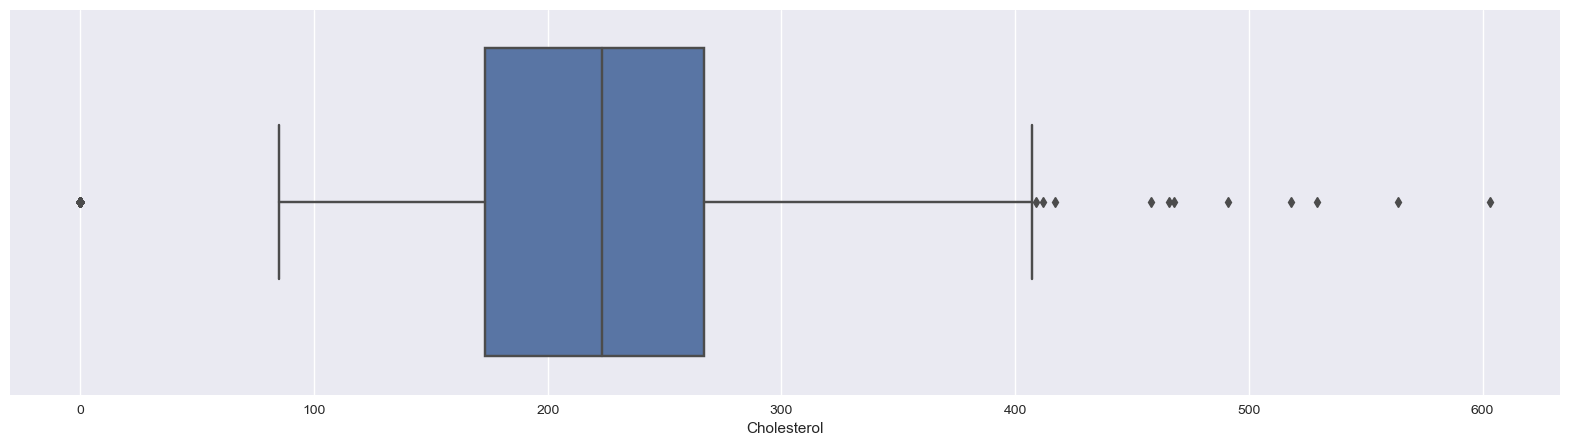

In [9]:
#Cholestrol outliers
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="Cholesterol")

In [10]:
# Delete Outliers
not_outliers_chol, outliers_chol = detect_outliers('Cholesterol')
print(f'Outliers in cholesterol represent the {round((outliers_chol.shape[0]*100)/df.shape[0], 2)}% of our dataset')
outliers_chol

Outliers in cholesterol represent the 19.93% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
28,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
69,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
103,40,M,ASY,120,466,1,Normal,152,Y,1.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1
536,62,M,NAP,133,0,1,ST,119,Y,1.2,Flat,1
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0
667,65,F,NAP,140,417,1,LVH,157,N,0.8,Up,0


In [11]:
# Delete Outliers - Cholestrol with 19.93% 0 Values
df = delete_outliers(outliers_chol[outliers_chol["Cholesterol"] == 0])

<AxesSubplot:xlabel='Cholesterol', ylabel='Count'>

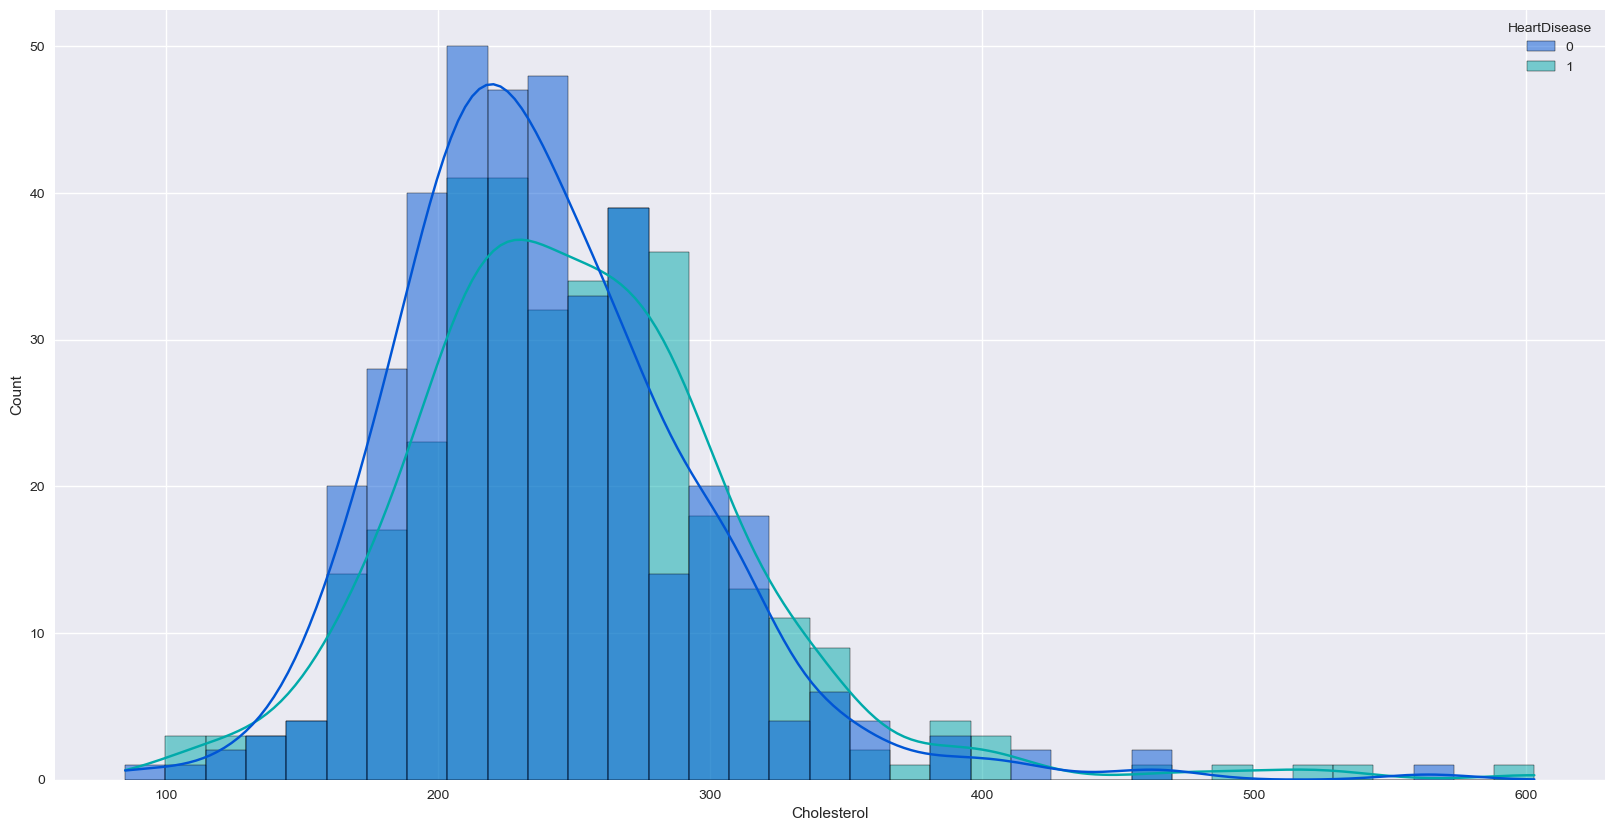

In [12]:
# Visualize Cholestrol for outliers
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='Cholesterol', kde=True, palette=color, hue='HeartDisease')

#Todo : To check if Cholestrol Means have to be assigned

In [13]:
# Detect  - Resting BP Outliers 
not_outliers_rbp, outliers_rbp = detect_outliers('RestingBP')
print(f'Outliers in resting blood pressure represent the {round((outliers_rbp.shape[0]*100)/df.shape[0], 2)}% of our dataset')
outliers_rbp

Outliers in resting blood pressure represent the 4.29% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
86,65,M,ASY,170,263,1,Normal,112,Y,2.0,Flat,1
109,39,M,ATA,190,241,0,Normal,106,N,0.0,Up,0
123,58,F,ATA,180,393,0,Normal,110,Y,1.0,Flat,1
132,56,M,ASY,170,388,0,ST,122,Y,2.0,Flat,1
189,53,M,ASY,180,285,0,ST,120,Y,1.5,Flat,1
190,46,M,ASY,180,280,0,ST,120,N,0.0,Up,0
191,50,M,ATA,170,209,0,ST,116,N,0.0,Up,0
215,30,F,TA,170,237,0,ST,170,N,0.0,Up,0
241,54,M,ASY,200,198,0,Normal,142,Y,2.0,Flat,1
274,45,F,ATA,180,295,0,Normal,180,N,0.0,Up,0


<AxesSubplot:xlabel='RestingBP', ylabel='Count'>

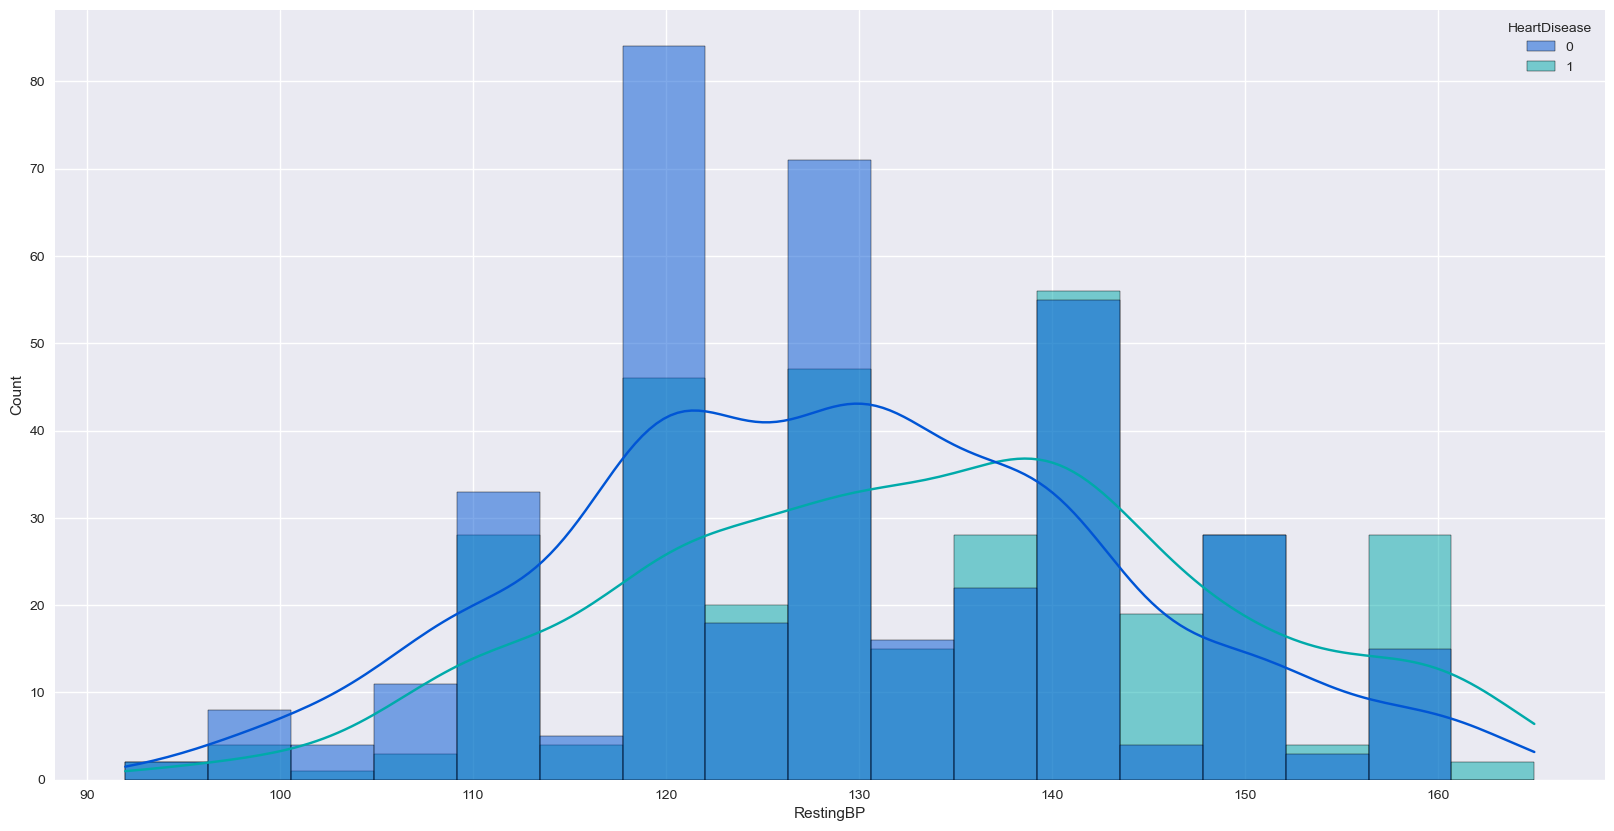

In [14]:
# cleanup - Resting BP Outliers
df = delete_outliers(outliers_rbp)
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='RestingBP', kde=True, palette=color, hue='HeartDisease')

<b>---------------------Delete any Values -----------------------</b>

In [ ]:
# No Data to Delete, Update or Impute

<b>---------------------Impute any Missing Values -----------------------</b>

In [115]:
# No Missing Values. 

<b>##################################################Data Reduction#########################################################</b>

In [140]:
# Remove Non Critical Colummsn
# Remove Columns wiht Lower Correlations

<b>##################################################Data Transformation#########################################################</b>

<b>--------------------------Variable Separation-----------------------------</b>

In [15]:
continuos_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_features = ["ChestPainType", "RestingECG", "ST_Slope"]
binaries_features = ["Sex", "FastingBS", "ExerciseAngina"]

<b>--------------------------------Encoding ( Binary Features )----------------------------------</b>

In [16]:
# Binary features enconding
df["Sex"] = df["Sex"].map({'M':1, 'F':0})
df["ExerciseAngina"] = df["ExerciseAngina"].map({'N':0, 'Y':1})
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144,193,1,Normal,141,0,3.4,Flat,1
915,57,1,ASY,130,131,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130,236,0,LVH,174,0,0.0,Flat,1


<b>--------------------------------------Data Binning-------------------------------------</b>

In [17]:
df_bin = df.copy()
for feature in continuos_features:
    bins = 5
    df_bin[feature] = pd.cut(df[feature], bins=bins, labels=range(bins)).astype(np.int64)
df_bin

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,1,1,ATA,3,1,0,Normal,3,0,0,Up,0
1,2,0,NAP,4,0,0,Normal,3,0,0,Flat,1
2,0,1,ATA,2,1,0,ST,1,0,0,Up,0
3,2,0,ASY,3,1,0,Normal,1,1,1,Flat,1
4,2,1,NAP,3,1,0,Normal,1,0,0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,1,TA,1,1,0,Normal,2,0,1,Flat,1
914,4,1,ASY,3,1,1,Normal,2,0,2,Flat,1
915,2,1,ASY,2,0,0,Normal,1,1,1,Flat,1
916,2,0,ATA,2,1,0,LVH,3,0,0,Flat,1


<b>--------------------------------Encoding ( Continuous & Categorical Features )----------------------------------</b>

In [18]:
# Typically Feature sets are One Hot Encoded, while the Target if required is Label Encoded
df_dumm = pd.get_dummies(df_bin, columns = categorical_features+continuos_features)
df_dumm

,Sex,FastingBS,ExerciseAngina,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,0,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
914,1,1,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
915,1,0,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
916,0,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


<b>-----------------------------------------------Data Scaling------------------------------------</b>

In [139]:
# No Scaling Required

<b>----------------------------------------Correlations between Features & Target--------------------------------------</b>

In [23]:
df_corr = df_dumm.corr()
df_corr["HeartDisease"].sort_values(ascending=False)

HeartDisease         1.000000
ST_Slope_Flat        0.595251
ExerciseAngina       0.548979
ChestPainType_ASY    0.523843
Sex                  0.306487
Oldpeak_1            0.297261
Oldpeak_2            0.261787
MaxHR_1              0.246226
Age_3                0.234047
FastingBS            0.148923
Oldpeak_3            0.126768
ST_Slope_Down        0.122051
RestingBP_4          0.110814
RestingBP_3          0.108064
MaxHR_0              0.102105
RestingECG_ST        0.099583
MaxHR_2              0.083049
Age_4                0.077150
Oldpeak_4            0.069091
RestingECG_LVH       0.063949
Cholesterol_4        0.042235
Cholesterol_2        0.033673
Cholesterol_3        0.019554
Cholesterol_1       -0.007950
RestingBP_2         -0.030745
Age_2               -0.037033
Cholesterol_0       -0.038955
ChestPainType_TA    -0.042540
RestingBP_0         -0.074276
RestingBP_1         -0.115718
RestingECG_Normal   -0.130259
Age_0               -0.135895
Age_1               -0.166444
MaxHR_4   

<b>------------------------------Check for Imbalanced Data-----------------------------------</b>

In [152]:
# Check for Imbalanced Target Feature 

In [24]:
#Data is well balanced.
df_dumm['HeartDisease'].value_counts()

0    379
1    335
Name: HeartDisease, dtype: int64

<b>----------------------Division into Training and Test Datasets--------------------------</b>

In [25]:
df_clean = df_dumm.copy()

X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train

,Sex,FastingBS,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
222,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
680,1,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
114,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
637,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
792,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,1,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
100,1,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
94,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
26,1,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [26]:
X_test

,Sex,FastingBS,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
13,1,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
771,1,0,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
220,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
795,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
537,1,1,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
473,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
693,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
77,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


<b>######################################################Data Modeling - Training & Testing ##################################################</b>

In [158]:
# Modeling Strategy 
# Case Negative : Patients with "No CVD" or No Condition ( NC)
# Case Positive : Patients with "CVD"
# TN : The prediction tells us that the patient has NC when actually has NC.
# TP: The prediction tells us that the patient has CVDs when actually has CVDs.
# FN: The prediction tells us that the patient has NC when actually has CVDs. ( Worst Case )
# FP: The prediction tells us that the patient has CVDs when actually has NC.

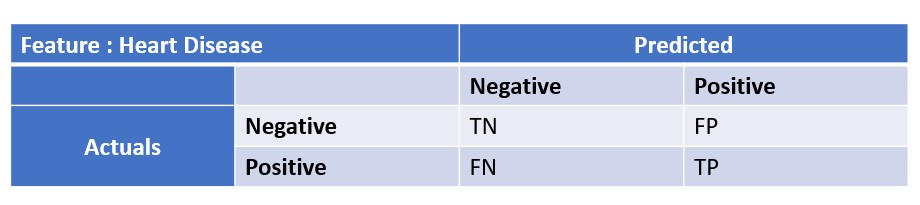

In [ ]:
# Important Model Scores

# 1. Accuracy : Accuracy tells you how many times the ML model was correct overall.
#    100 Predictions, 73 are correct, accuracy is 73%

# 2. Precision : Model metric we use to select our best model when there is a high cost associated with False Positive (FP) 
#    When the costs of False Positive is high. For instance, email spam detection. 
#    In email spam detection, a false positive means that an email that is non-spam (actual negative) has been predicted as spam (predicted spam).  

# 3. Recall :  Model metric we use to select our best model when there is a high cost associated with False Negative (FN) 
#    If a fraudulent transaction (Actual Positive) is predicted as non-fraudulent (Predicted Negative)

# 4. F1-Score  :  The accuracy metric computes how many times a model made a correct prediction across the entire dataset
#    Performance measure for classification and often preferred over, for example, accuracy when data is unbalanced

In [27]:
metric = 'recall'

In [28]:
cv = 15
nFeatures = len(X_train.columns)

def print_scores(y, y_pred):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred)*100, recall_score(y, y_pred)*100, f1_score(y, y_pred, average='weighted')*100
    print(f"Accuracy:{ac}")
    print(f"Precision:{pr}")
    print(f"Recall:{rc}")
    print(f"F1-score:{f1}")
    return {'ac': ac, 'pr':pr, 'rc':rc, 'f1':f1}

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1]) 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Poisitive Rate")

<b>--------------------------K-Nearest Neighbors Classifier--------------------------</b>

In [29]:
param_grid = [{
    'n_neighbors':np.arange(5, 21),
    'weights':['uniform', 'distance'],
    'p':[1, 2],
}]

knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, param_grid, cv=cv, scoring=metric)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                          'p': [1, 2], 'weights': ['uniform', 'distance']}],
             scoring='recall')

In [30]:
best_knn_clf = grid_knn.best_estimator_
grid_knn.best_params_

{'n_neighbors': 16, 'p': 1, 'weights': 'distance'}

<AxesSubplot:>

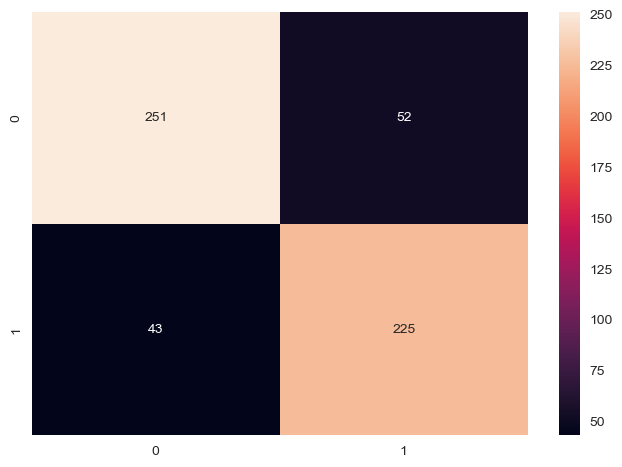

In [31]:
y_train_pred = cross_val_predict(best_knn_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

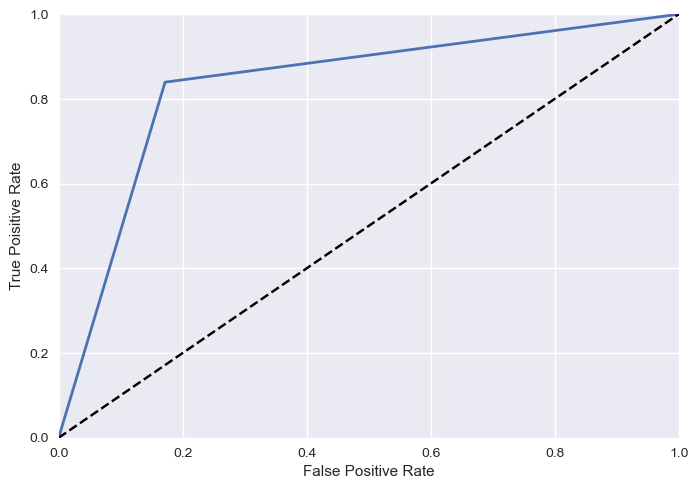

In [32]:
# Plot the ROC Curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [33]:
roc_auc_score(y_train, y_train_pred)

0.8339675385448992

<AxesSubplot:>

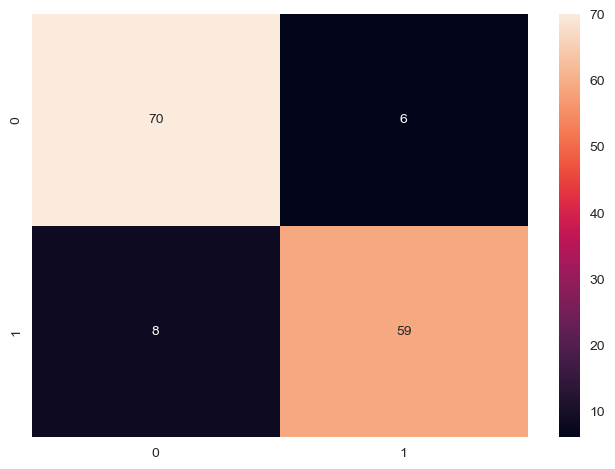

In [34]:
# Evaluate the Model
y_test_pred = cross_val_predict(best_knn_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

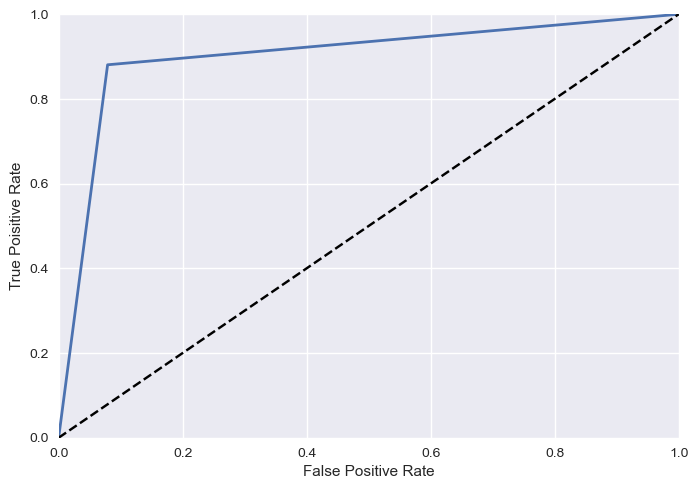

In [35]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [36]:
roc_auc_score(y_test, y_test_pred)

0.9008248232521603

In [37]:
knn_scores = print_scores(y_test, y_test_pred)

Accuracy:90.20979020979021
Precision:90.76923076923077
Recall:88.05970149253731
F1-score:90.1991947446493


<b>------------------------------------C-Support Classifier----------------------------------</b>

In [38]:
# Train the model 
param_grid = [{
    "C": np.linspace(1, 1.5, 10),
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto']
}]

svc_clf = SVC()
grid_svc = GridSearchCV(svc_clf, param_grid, scoring=metric, cv=cv)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=SVC(),
             param_grid=[{'C': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='recall')

In [39]:
best_svc_clf = grid_svc.best_estimator_
grid_svc.best_params_

{'C': 1.2222222222222223, 'gamma': 'scale', 'kernel': 'rbf'}

<AxesSubplot:>

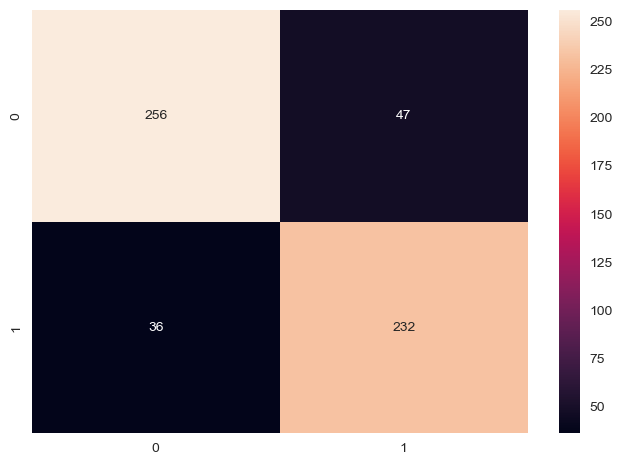

In [40]:
y_train_pred = cross_val_predict(best_svc_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

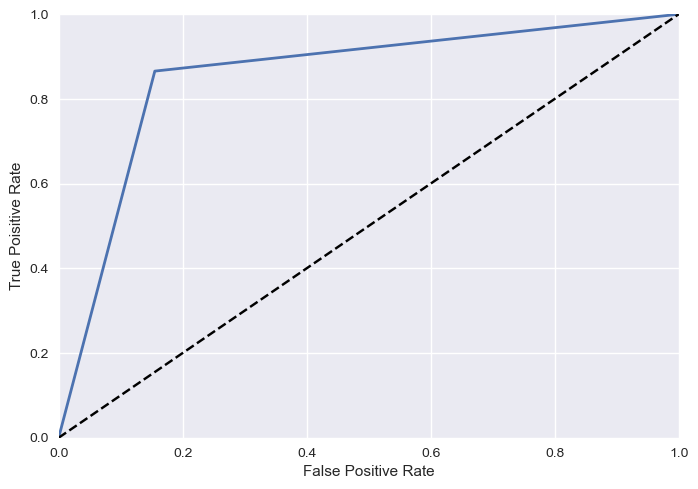

In [41]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [42]:
roc_auc_score(y_train, y_train_pred)

0.8552780651199448

<AxesSubplot:>

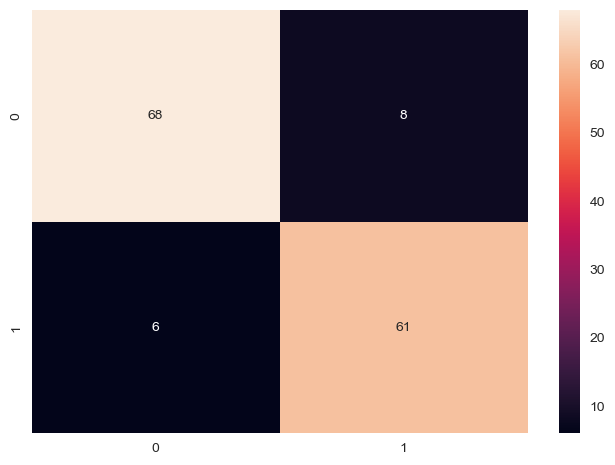

In [43]:
# Evaluate the Model
y_test_pred = cross_val_predict(best_svc_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

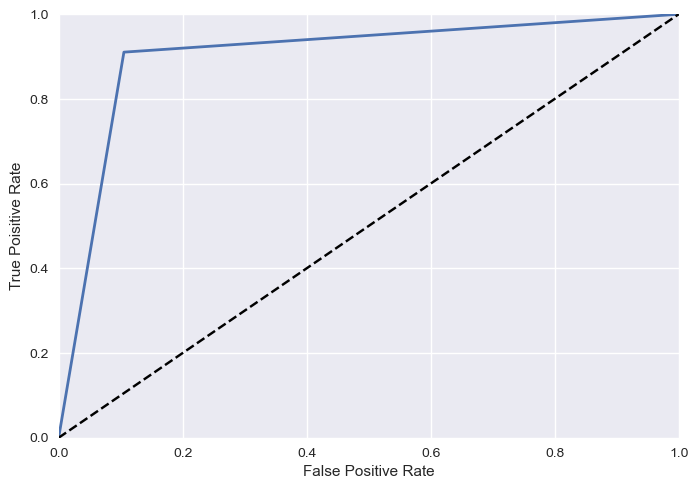

In [44]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [45]:
roc_auc_score(y_test, y_test_pred)

0.9025923016496465

In [46]:
svc_scores = print_scores(y_test, y_test_pred)

Accuracy:90.20979020979021
Precision:88.40579710144928
Recall:91.04477611940298
F1-score:90.21650898121486


<b>-----------------------------------Random Forest Classifier----------------------------------</b>

In [47]:
nFeatures

38

In [48]:
param_grid = [{"n_estimators":[650, 700, 750, 800],
               'criterion':['gini','entropy'],
               "max_features":[nFeatures-9, nFeatures-8, nFeatures-5]
              }]
rf_clf = RandomForestClassifier(random_state=42)
grid_forest = GridSearchCV(rf_clf, param_grid, cv=cv, scoring=metric)
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': [29, 30, 33],
                          'n_estimators': [650, 700, 750, 800]}],
             scoring='recall')

In [49]:
best_rf_clf = grid_forest.best_estimator_
best_rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 29,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 750,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

<AxesSubplot:>

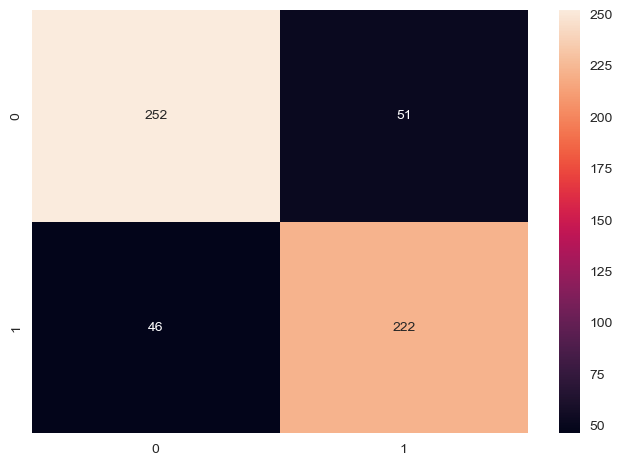

In [51]:
y_train_pred = cross_val_predict(best_rf_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

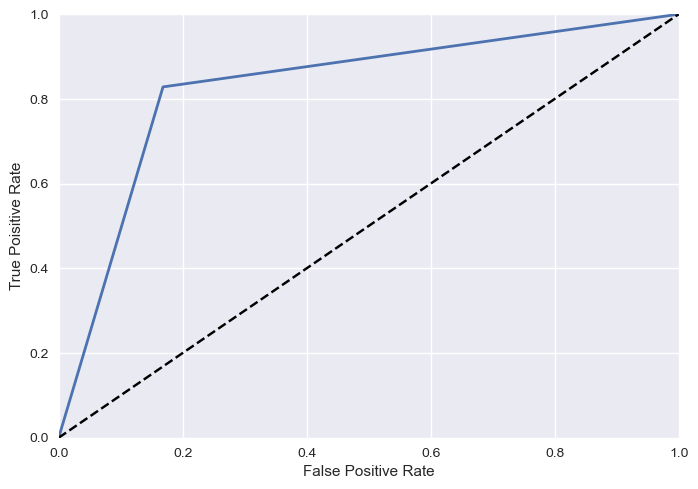

In [52]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [53]:
roc_auc_score(y_train, y_train_pred)

0.8300206886360277

In [59]:
X_test

,Sex,FastingBS,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
13,1,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
771,1,0,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
220,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
795,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
537,1,1,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
473,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
693,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
77,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [60]:
y_test

13     1
771    1
220    1
795    0
537    1
      ..
692    0
473    1
693    0
77     0
265    0
Name: HeartDisease, Length: 143, dtype: int64

<AxesSubplot:>

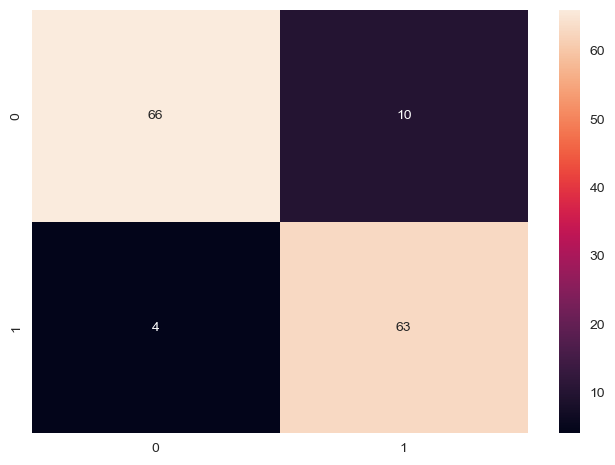

In [ ]:
y_test_pred = cross_val_predict(best_rf_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

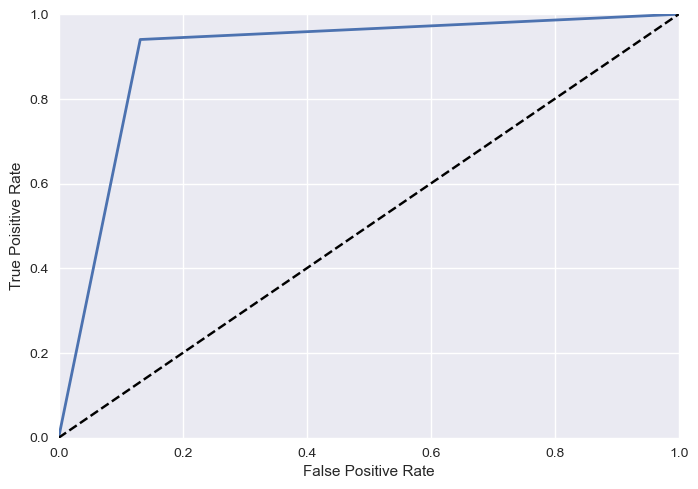

In [55]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [56]:
roc_auc_score(y_test, y_test_pred)

0.9043597800471328

In [57]:
rf_scores = print_scores(y_test, y_test_pred)

Accuracy:90.20979020979021
Precision:86.3013698630137
Recall:94.02985074626866
F1-score:90.21841172526105


<b> -----------------------------------------Model Evaluation & Selection--------------------------------</b>

In [58]:
# Accuracy and Precision for K-Nearest Neighbours was the best
scores = pd.DataFrame(data=[list(knn_scores.values()), list(svc_scores.values()), list(rf_scores.values())], columns=list(knn_scores.keys()))
scores = scores.transpose()
scores = scores.rename(columns={0:"K-Nearest Neighbors", 1:"C-Support Vector", 2:"Random Forest"})
scores.style.highlight_max(color = 'green', axis = 1)

,K-Nearest Neighbors,C-Support Vector,Random Forest
ac,90.209790,90.209790,90.209790
pr,90.769231,88.405797,86.301370
rc,88.059701,91.044776,94.029851
f1,90.199195,90.216509,90.218412
